In [1]:
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
import os
warnings.filterwarnings('ignore')
import math

In [2]:
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)Dimension of parameter space : d
4)State Space
5)Action Space
6)Transition probability matrix of size (a,s,s)
7)Reward matrix (a,s,s)
8) Feature approximation vector of size (a,s,d) for score function and policy update
9) Feature approximation vector phi of size (s,d) for Temporal Difference Error update
10) policy pi of size (s,a)
11) optimal policy for testing
12) Temporal Difference Error
13) Initial probability distribution xi
14) discount factor
15) critic parameter thetas
'''
class MarkovDP:
    
    def __init__(self,s,a,d,T, discount_factor):
        self.num_state             = s
        self.num_action            = a
        self.dimension             = d
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        self.feature_approx        = np.zeros((a,s,d))
        self.phi                   = np.zeros((s,d))
        self.pi                    = np.zeros((s, a))
        self.optimal_pi            = np.zeros((s, a))
        self.TDerror               = np.zeros((a,s,s))
        self.xi                    = np.zeros(s)
        self.discount_factor       = discount_factor
        self.thetas                = np.zeros((T+1, d))
    
    #mdp created to test the policy_eval and optimal_policyValue methods
    def test_mdp(self):
        self.transitions[0] = [[0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1], [1,0,0,0,0]]
        self.transitions[1] = [[1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1]]
        self.transitions[2] = [[0,0,0,0,1], [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0]]
        self.feature_approx = np.random.rand(self.num_action, self.num_state, self.dimension)
        self.phi = np.random.rand(self.num_state, self.dimension)
        self.thetas[0] = np.random.rand(self.dimension)
        self.xi = np.full((self.num_state), (1.0/self.num_state))
        for i in range(0,5):
            for j in range(0,5):
                self.rewards[0][i][j] = 0.2
                self.rewards[1][i][j] = 0.1
                self.rewards[2][i][j] = 0
        for i in range(0, self.num_state):
            self.pi[i] = np.full((self.num_action), (1.0/self.num_action))
            self.optimal_pi[i] = np.full((self.num_action), (1.0/self.num_action))
     
    #initializes MDP
    def initialize_mdp(self):   
      #for reproducibility 
        np.random.seed(0)   
        self.rewards = np.random.rand(self.num_action, self.num_state, self.num_state)
        self.feature_approx = np.random.rand(self.num_action, self.num_state, self.dimension)
        self.phi = np.random.rand(self.num_state, self.dimension)
        self.thetas[0] = np.random.rand(self.dimension)
        self.xi = np.full((self.num_state), (1.0/self.num_state))
        for i in range (0, self.num_action):
            for j in range(0, self.num_state):
                self.transitions[i][j] = np.random.dirichlet(np.ones(self.num_state, dtype = np.int8),size=1)
        for i in range(0, self.num_state):
            self.pi[i] = np.random.dirichlet(np.ones(self.num_action, dtype = np.int8),size=1)
            self.optimal_pi[i] = np.random.dirichlet(np.ones(self.num_action, dtype = np.int8),size=1)
    
    #log gradient of policy
    def score_function(self, action, state):
        score = self.feature_approx[action][state]
        for i in range(0, self.num_action):
            score = score - (self.pi[state][i] * self.feature_approx[i][state])
        return score
    
    #updates the policy using a softmax function
    def update_policy(self, actor_parameter):
        for i in range(0, self.num_state):
            sum = 0
            for j in range(0, self.num_action):
                sum += math.exp(np.dot(actor_parameter, self.feature_approx[j][i]))
            for j in range(0, self.num_action):
                self.pi[i][j] = ((math.exp(np.dot(actor_parameter, self.feature_approx[j][i]))) / sum)
     
    #evaluates the policy and finds its value function
    def policy_eval(self, pi, gamma):
        policy_rewards = np.zeros(self.num_state)
        for i in range(0, self.num_state):
            sum = 0
            for j in range(0, self.num_action):
                reward_sum = 0
                for k in range(0, self.num_state):
                    reward_sum += self.rewards[j][i][k]
                sum += (pi[i][j] * reward_sum)
            policy_rewards[i] = sum
        policy_transitions = np.zeros((self.num_state, self.num_state))
        for i in range(0, self.num_state):
            for j in range(0, self.num_state):
                sum = 0
                for k in range(0, self.num_action):
                    sum += (self.transitions[k][i][j] * pi[i][k])
                policy_transitions[i][j] = sum
        value_func = (np.dot(np.linalg.inv(np.identity(self.num_state) - (gamma * policy_transitions)),policy_rewards))
        return value_func
    
    #calculates the optimal policy for the given MDP
    def optimal_policyValue(self):
        policy_stable = False
        value_func = self.policy_eval(self.optimal_pi, self.discount_factor)
        while(not policy_stable):
            policy_stable= True
            for i in range(0, self.num_state):
                old_action = np.random.choice(self.actions, p = self.optimal_pi[i])
                max = np.zeros(2)
                for j in range(0, self.num_action):
                    sum = 0
                    for k in range(0, self.num_state):
                        sum += (self.transitions[j][i][k] * (self.rewards[j][i][k] + (self.discount_factor * value_func[k])))
                    if (sum > max[0]):
                        max[0] = sum
                        max[1] = j
                policy_dist = np.zeros(self.num_action)
                policy_dist[int(max[1])] = 1
                self.optimal_pi[i] = policy_dist
                if (old_action != np.random.choice(self.actions, p = self.optimal_pi[i])):
                    policy_stable = False
        value_func = self.policy_eval(self.optimal_pi, self.discount_factor)
        return value_func
    
    #updates critic parameter
    def minibatch_TD(self, sIni, critic_stepsize, T_current, M):
        states = np.zeros((T_current, M+1), dtype = int)
        for i in range (0,T_current):
            if (i == 0):
                states[i][0] = sIni
            else:
                states[i][0] = states[i-1][M]
            action = np.zeros(M, dtype = int)
            for j in range(0, M):
                action[j] = np.random.choice(self.actions, p = self.pi[states[i][j]])
                states[i][j+1] = np.random.choice(self.states, p = ((self.discount_factor * self.transitions[action[j]][states[i][j]][:]) + ((1 - self.discount_factor) * self.xi)))
                self.TDerror[action[j]][states[i][j]][states[i][j+1]] = self.rewards[action[j]][states[i][j]][states[i][j+1]] + (self.discount_factor * np.dot(self.phi[states[i][j+1]], self.thetas[i])) - (np.dot(self.phi[states[i][j]], self.thetas[i]))
            sum = 0
            for k in range(0, M):
                sum += ((self.TDerror[action[k]][states[i][k]][states[i][k+1]]) * self.phi[states[i][k]])
            self.thetas[i+1] = self.thetas[i] + (critic_stepsize * (1.0/M) * sum)
        if T_current == 0:
            return (self.thetas[T_current], sIni)
        else:
            return (self.thetas[T_current], states[T_current - 1][M])
    
    #runs ac algorithm
    def actor_critic_alg(self, actor_stepsize, critic_stepsize, regularization, isNAc, T, B):
        actor_parameter = np.zeros((T+1,self.dimension))
        actor_parameter[0] = np.random.rand(self.dimension)
        self.update_policy(actor_parameter[0])
        states = np.zeros((T, B+1), dtype = int)
        s0 = np.random.choice(self.states, p = self.xi)
        fisher = np.zeros((T, self.dimension, self.dimension))
        M = 10
        
        optimal_value = self.optimal_policyValue()
        optimal_value = (np.sum(optimal_value) / self.num_state)
        value_diff = np.zeros(T)
        for i in range (0,T):
            if(i == 0):
                sIni = s0
            else:
                sIni = states[i-1][B]
            self.thetas[i], states[i][0] = self.minibatch_TD(sIni, critic_stepsize, i, M)
            action = np.zeros(B, dtype = int)
            for j in range (0,B):
                action[j] = np.random.choice(self.actions, p = self.pi[states[i][j]])
                states[i][j+1] = np.random.choice(self.states, p = ((self.discount_factor * self.transitions[action[j]][states[i][j]][:]) + ((1 - self.discount_factor) * self.xi)))
                self.TDerror[action[j]][states[i][j]][states[i][j+1]] = self.rewards[action[j]][states[i][j]][states[i][j+1]] + (self.discount_factor * np.dot(self.phi[states[i][j+1]], self.thetas[i])) - (np.dot(self.phi[states[i][j]], self.thetas[i]))
                fisher[i] = fisher[i] + (1/B) *(self.score_function(action[j], states[i][j]) * self.score_function(action[j], states[i][j]))
            sum = 0
            for k in range(0, B):
                sum += ((self.TDerror[action[k]][states[i][k]][states[i][k+1]]) * self.score_function(action[k], states[i][k]))
            if(not isNAc):
                actor_parameter[i+1] = actor_parameter[i] + (actor_stepsize * (1.0/B) * sum)
                self.update_policy(actor_parameter[i+1])
                value_func = self.policy_eval(self.pi, self.discount_factor)
                value_diff[i] = (optimal_value - (np.sum(value_func) / self.num_state))
            else:
                actor_parameter[i+1] = actor_parameter[i] + (np.dot((actor_stepsize * np.linalg.inv(fisher[i] + (regularization * np.identity(self.dimension)))), ((1.0/B) * sum)))
                self.update_policy(actor_parameter[i+1])
                value_func = self.policy_eval(self.pi, self.discount_factor)
                value_diff[i] = (optimal_value - (np.sum(value_func) / self.num_state))
        return (actor_parameter[np.random.randint(0,T)], np.arange(T), value_diff)

In [3]:
d = 6
env = MarkovDP(5,3,d,500, 0.9)
env.initialize_mdp()

In [4]:
wT, x, y = env.actor_critic_alg(0.8, 0.8, 0.5, True, 500, 200)

[[0.52167495 0.29525339 0.18307167]
 [0.6862333  0.00950532 0.30426139]
 [0.31732853 0.47058296 0.21208851]
 [0.66731462 0.23672456 0.09596082]
 [0.55603741 0.34891618 0.09504641]]
[[0.28628364 0.02935092 0.68436543]
 [0.34037777 0.64706576 0.01255647]
 [0.01695073 0.98149911 0.00155016]
 [0.89843125 0.03801544 0.06355331]
 [0.02832138 0.02360287 0.94807575]]
[ 0.37395412 -0.11330115  0.19311928  0.16644461  0.8774134   1.44955086]


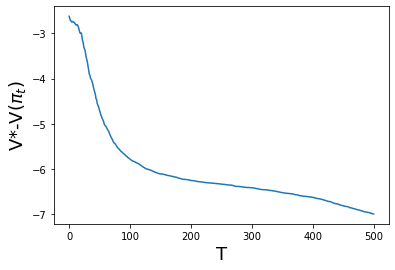

In [5]:
%matplotlib inline
plt.xlabel('T', fontsize=18)
plt.ylabel('V*-V($\pi_t$)', fontsize=18)
plt.plot(x, y)
plt.show()